# Élaboration de l'algorithme exact de résolution 
En l'état (vendredi 18/05), ce document présente :
* **Fonctions générales** : des fonctions pour **charger une instance** et obtenir des objets facile d'accès. Des fonctions (codées en `Cython`) permettent d'y accéder facilement
* **Arbres** : des fonctions relatives à un arbre : pour **générer** un tel arbre vérifiant toutes les contraintes (pour une suite d'objets placés donnée), les **afficher** et les **sauvegarder**
* **Emplacements** : des fonctions pour obtenir tous les emplacements possibles pour un item donné : ces emplacement vérifient la **condition de l'étoile verte**, évitent les **défauts** et permettent à la pièce de **tenir** dans le node
* **Séquence −> arbre admissible** : une première fonction mise en place afin de tester les fonctions précédentes : celle-ci place une séquence (suite d'items admissible).
* Un premier algorithme glouton basé sur l'optimisation locale d'un *score*.

*Remarque :* Ce document utilise `Cython` afin de compiler en C les (courtes) fonctions appelées régulièrement, dans un objectif d'accélerer grandement le programme (environ un facteur $×4$ pour des fonctions élémentaires : un gain plus important pour les fonctions très complexes).

Pour l'installation et l'utilisation, on se réfèrera à la documentation : http://docs.cython.org/en/latest/

In [85]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [86]:
import matplotlib.pyplot as plt
from functools import reduce

# Fonctions générales
Fonctions génériques sur les instances, notamment :
* Chargement du dataset sous forme de dataframe avec `pandas`
* Conversion du fichier de `batch` sous forme d'une matrice
* Chargement des paramètres sous forme de variables globales
* Conversion du `batch` sous forme d'une liste d'objets `Stack` : objets intelligents pour réimplémenter une pile sans supprimer les objets *retirés de la pile*.
* Chargement des défauts sous la forme d'un tableau où `list_def[bin_id]` est un dictionnaire contenant la liste des défauts triées selon `x` ou selon `y`).

#### Paramètres
(on pourrait lire les paramètres dans le fichier `.csv`)

In [87]:
nPlates = 100
widthPlates = 6000
heightPlates = 3210
minXX = 100
maxXX = 3500
minYY = 100
minWaste = 20

**Chargement du dataset**

In [88]:
import pandas as pd

path = "../checker/instances_checker/"
def load_instance(name = "A19"):
    instance = path + name
    defects = instance + "_defects.csv"
    batch = instance + "_batch.csv"
    
    defects = pd.read_csv(defects, sep = ";")
    batch = pd.read_csv(batch, sep = ";")
    
    return (defects, batch)

#### Objet stack

On créé un objet stack afin de ne pas supprimer des éléments des éléments *retirés* d'un stack.

L'idée est également d'avoir une structure pertinente pour pouvoir gérer des *fenêtres glissantes* (terme dangereux)
**(non implémenté pour le moment)**


In [89]:
class Stack:    
    def __init__(self, L):
        self.list = L
        self.n = len(L)
        self.begin = 0 # premier élément
        self.end = self.n  # juste après le dernier
        
    def pop(self):
        """
            Renvoie l'élément en tête et avance l'item
        """
        if not self.is_empty():
            self.begin += 1
            return self.list[self.begin - 1]
        
    def is_empty(self):   
        return self.end - self.begin == 0
    
    def push(self):
        """
            Ajoute artificiellement l'élément en tête 
            (décale juste le pointeur begin)
        """
        if self.begin > 0:
            self.begin -= 1
        
    def reset(self, begin = 0, end = -1):
        self.begin = begin
        
        if end == -1:
            self.end = self.n
        else:
            self.end = end
            
    def top(self):
        if not self.is_empty():
            return self.list[self.begin]
        else:
            return -1

Quelques fonctions viennent en complément de cet objet : afin de construire des séquences aléatoires.

In [90]:
from random import randint

def random_seq(stacks):
    seq = []
    
    for k in range(len(stacks)):
        stacks[k].reset()
    n = len(stacks)
    k = 0
    while k < sum([s.n for s in stacks]):
        p = randint(0, n - 1)
        if not stacks[p].is_empty():
            k += 1
            seq.append(stacks[p].pop())
            
    for k in range(n):
        stacks[k].reset()
    return seq

Fonction pour obtenir l'identifiant d'un stack non vide, étant donné la liste des stacks non-vides.

In [91]:
def random_stack(stacks_allowed):
    """
        * stacks est une liste de Stack
        * stacks_allowed est une liste des id stacks non vide [0, 2] si seulement les stacks 0 et 2 sont 
            non-vide.
    """
    n = len(stacks_allowed)
    if len(stacks_allowed) == 0:
        return -1    
    return stacks_allowed(randint(0, n - 1))
    

#### Conversion batch −> Stack

In [92]:
def convert_batch_into_list(batch):
    """
        Renvoie la liste list_stacks tq list_stacks[k] 
        est une liste d'indices dans le bon ordreê
        (TODO = meilleure implémentation d'une pile 
        pour 'revenir en arrière')
    """
    nStack = max(batch.STACK)
    list_stacks = []
    
    for k in range(nStack + 1):
        list_stacks.append(
            list(batch.loc[batch["STACK"] == k]
                 .sort_values("SEQUENCE").ITEM_ID))
        
    return list_stacks

def convert_batch_into_stacks(batch):
    stacks_list = convert_batch_into_list(batch)
    return [Stack(s) for s in stacks_list] 



#### Fonctions d'accès aux données
Plusieurs fonctions pour :
* Obtenir le stack d'un item (suppose `batch_mat` variable globale) 
* La largeur, la hauteur ou les deux pour un item et une orientation : ces fonctions prennent en paramètre `batch_mat` car codées en `Cython` afin de gagner en temps de calcul.

In [93]:
def get_stack(item):
    return batch_mat[item, 3]

In [94]:
%%cython
import numpy as np
cimport numpy as np

def width_height_mat(int item, int rotated, batch_mat):
    """
        Renvoie largeur et hauteur avec accès en C donc plus rapide
    """
    return (width_item(item, rotated, batch_mat), 
            height_item(item, rotated, batch_mat))

cpdef int width_item(int item, int rotated, np.ndarray batch_mat):
    if rotated:
        return batch_mat[item, 1]
    else:
        return batch_mat[item, 2]
    
cpdef int height_item(int item, int rotated, np.ndarray batch_mat):
    if rotated:
        return batch_mat[item, 2]
    else:
        return batch_mat[item, 1]

On remarque que le temps de calcul est très correct, de l'orde de $270$ns.

#### Chargement des défauts

In [95]:
def convert_defects_into_list(defects):
    """
        Renvoie la liste list_stacks tq list_stacks[k] 
        est une liste d'indices dans le bon ordre
        (TODO = meilleure implémentation d'une pile 
        pour 'revenir en arrière')
    """
    nDef = max(defects.PLATE_ID)
    list_def = []
    
    for k in range(nDef + 1):
        list_def.append(
            {"x":defects.loc[defects["PLATE_ID"] == k].sort_values("X").as_matrix(),
            "y":defects.loc[defects["PLATE_ID"] == k].sort_values("Y").as_matrix()
            })
        
    return list_def



In [96]:
def load_complete_instance(name):
    (defects, batch) = load_instance(name)
    batch_mat = batch.as_matrix()
    stacks = convert_batch_into_stacks(batch)
    list_def = convert_defects_into_list(defects)
    return (defects, batch, batch_mat, stacks, list_def)
(defects, batch, batch_mat, stacks, list_def) = load_complete_instance("A11")

# Arbres

Un arbre est une *suite* de listes (car modifiables) : `[x, y, largeur, hauteur, profondeur, [liste d'enfants], type]`

```python

tree = [0, 0, widthPlates, heightPlates, -2, [
    [0, 0, w, heightPlates, -2,[
        [0, 0, w, h, 1, []],
        [0, h, w, heightPlates - h, -3,[]]
    ],
    [w, 0, widthPlates - w, heightPlates, -2, []]]
]]
```

Le type des nœuds est le suivant : **il n'est pas BIEN géré pour le moment**
* $>0$ : un item 
* $-1$ : un déchet
* $-2$ : un nœud
* $-3$ : zone résiduelle

*Remarque* : Il serait peut-être plus intéressant de créer un tuple ? Les deux seules modifications sont :
1. La liste des enfants
2. Le type (car déterminé à la toute fin)

### Création de l'arbre à partir d'un cutting pattern

Algorithme plutôt simple, il construit un **arbre prioritaire** dans le sens où chaque coupe est faite dès que possible.

Une coupe est considérée comme valide si elle vérifie plusieurs conditions :
* **Coupes guillotines** : la coupe ne traverse **aucune pièce**, ni **aucun défaut**
* **Ordre admissiple** : la coupe ne sépare pas des séquences de pièces (1, 2, 3, 4, 5) ne peut être découpée en (1, 2, 4) et (3, 5). 
>*Remarque* : Cette contrainte porte sur la séquence donnée en paramètre, mais une autre séquence pourrait être être admissible.
* **1-cut** : 
 * la **largeur minimale** entre deux 1-coupe consécutives doit être de `minXX` (= 100), sauf pour les déchets
 * la **largeur maximale** entre deux 1-coup consécutes doit être de `maxXX` (= 3500), sauf pour les déchets (ou la zone résiduelle) 
* **2-cut** : la hauteur minimale entre deux 2-coupes est de `minYY` (= 100), sauf pour les déchets
* Les zones de déchets sont de dimensions au minimum $20 \times 20$

**Attention**, la coupe guillotine sur un défaut ainsi que la condition $20\times20$ ne sont pas encore pris en compte.

La fonction ci-dessous renvoie une exception s'il est impossible de construire un arbre.

In [97]:
# -2 branch, -1 waste, -3 residual
node = [0, 0, widthPlates, heightPlates, 0, [], -2]
items = [(0, 0, 0, True), (10, 800, 1000, False), (2, 1500, 1000, False), (3, 2000, 1000, True)]
def gen_tree(node, items):
        
    [XX, YY, WW, HH, depth, sons, _] = node
    
    if WW < 20 or HH < 20:
        raise Exception("Waste too small")
        
    if len(items) == 0:
        node[6] = -1
        return node
    
            
    n = len(items)
    
    if n == 1 and \
        items[0][1] == XX and items [0][2] == YY and\
        width_item(items[0][0], items[0][3], batch_mat) == WW and\
        height_item(items[0][0], items[0][3], batch_mat) == HH:
            node[6] = items[0][0]
            #print(node[6])
            return node
        
    if depth > 3:
        #print(node)
        raise  Exception("Tree too depth")

    if depth % 2 == 0: # découpe verticale
        # + 0.1 pour faire en sorte que la pièce commence juste après la découpe
        L = [(item[1] + .1, -1, -1) for item in items] +\
            [(items[k][1] + width_item(items[k][0], items[k][3], batch_mat), k) for k in range(n)]  
        L.sort()
        #print(L)
        cuts = []
        opened = 0
        max_item = -1
        n_items = 0
        #print(L)
        for x in L:
            if opened == 0 and max_item + 1 == n_items:
                    cuts.append((int(x[0]), n_items))        
                    
            if x[1] == -1:
                opened += -1
            else:
                opened += 1
                max_item = max(max_item, x[1])
                n_items += 1
                if opened == 0 and max_item + 1 == n_items:
                    cuts.append((int(x[0]), n_items))   
                    
        #print(cuts)
        xprev = XX
        niprev = 0
        if depth == 0:
            for (x, ni) in cuts:
                if ni > 0 and (0 < x - xprev < 100 or x - xprev > 3500):
                    #print(node)
                    #print(x, ni)
                    raise Exception("1-cut constrain violated")
                
                xprev = x
                niprev = ni
                
        xprev = XX
        niprev = 0
        for (x, ni) in cuts:
            try:
                #print(x)
                #print(items[niprev:ni])
                #print(niprev, ni)
                if x != xprev:
                    node[5].append(gen_tree([xprev, YY, x - xprev, HH, depth + 1, [], -2], items[niprev:ni]))
                xprev = x
                niprev = ni
                
            except Exception as error:
                raise error
            
        if XX + WW != xprev:
            node[5].append(gen_tree([xprev, YY, XX + WW - xprev, HH, depth + 1, [], -2], []))
             
        return node 
    
    else: # découpe horizontale
        # + 0.1 pour faire en sorte que la pièce commence juste après la découpe
        L = [(items[k][2] + 0.1, -1, k) for k in range(n)] +\
            [(items[k][2] + height_item(items[k][0], items[k][3], batch_mat), k) for k in range(n)]  
        L.sort()

        cuts = []
        opened = 0
        max_item = -1
        n_items = 0
        for x in L:            
            if opened == 0 and max_item + 1 == n_items:
                    cuts.append((int(x[0]), n_items))        
                    
            if x[1] == -1:
                opened += -1
            else:
                opened += 1
                max_item = max(max_item, x[1])
                n_items += 1
                if opened == 0 and max_item + 1 == n_items:
                    cuts.append((x[0], n_items))
                # le reste, il n'y a pas de défauts
        
        #print(cuts)
        xprev = YY
        niprev = 0
        if depth == 0:
            for (y, ni) in cuts:
                if ni > 0 and 0 < y - yprev < 100:
                    raise Exception("2-cut constrain violated")
                
                yprev = y
                niprev = ni
               
        ns = 0    
        yprev = YY
        niprev = 0
        for (y, ni) in cuts:
            try:
                #print(node)
                if y != yprev:
                    node[5].append(gen_tree([XX, yprev, WW,  y - yprev, depth + 1, [], -2],items[niprev:ni]))
                    ns += 1
                yprev = y
                niprev = ni
                
            except Exception as error:
                raise error
                
        if YY + HH != yprev:
            ns += 1
            node[5].append(gen_tree([XX, yprev, WW, YY + HH - yprev, depth + 1, [], -2], []))
         
        if depth == 3 and ns > 2:
            raise Exception("Trimming failed")
        return node 


### Affichage  d'un arbre  
On trace les arbres en traçant les nœuds (rectangles en rouge), les items (une couleur par stack) et le numéro de l'item.

La fonction `draw_trees` permet de tracer plusieurs arbres avec des `subplots`.

In [98]:
colors_stacks = [(255, 62, 150), (205, 105, 201), (0, 0, 255), 
          (188, 210, 238), (0, 206, 209), (0, 205, 102), 
          (255, 255, 0), (128, 128, 0), (255, 165, 0), 
          (255, 140, 0), (255, 99, 71), (170, 170, 170)]

In [99]:
import cv2
def draw_tree(tree, bin_id):
    r = 10
    img = np.zeros((heightPlates//r, widthPlates//r, 3), np.uint8)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    def draw_rect_recursive(node, img):
        [x, y, w, h, depth, sons, t] = node
        
        # Placement des pièces = couleur + id
        if t > -1:
            img = cv2.rectangle(img, (int(x//r), int(y//r)), 
                                (int((x + w)//r), int((y + h)//r)), 
                                colors_stacks[min(11, get_stack(t))], -1)
            cv2.putText(img, str(t), (int((x)//(r)), int((y + h//2)//(r))) , font, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Dessin du contour (en rouge)
        img = cv2.rectangle(img, (int(x//r), int(y//r)), (int((x + w)//r), int((y + h)//r)), (255, 0, 0), 2)          
            
        for n in sons:
            img = draw_rect_recursive(n, img)
        
        # Placement des défauts
        for k in range(len(list_def[bin_id]["x"][:, 2])):
            [xd, yd, wd, hd] = list_def[bin_id]["x"][k, [2, 3, 4, 5]]
            
            # cercle plutôt qu'un rectangle
            #img = cv2.rectangle(img, (int(xd//r), int(yd//r)), (int((xd + wd)//r), int((yd + hd)//r)), (0, 255, 0), -1)
            
            img = cv2.circle(img, (int((xd + wd/2)//r), int((yd + hd/2)//r)), 4, (0, 255, 0), -1) 
            
        return img
    draw_rect_recursive(tree, img)


    plt.imshow(img)
    plt.xticks(np.arange(0, widthPlates + 1, 1000)//r, np.arange(0, widthPlates + 1, 1000))
    plt.yticks(np.arange(0, heightPlates + 1, 500)//r, np.arange(0, heightPlates + 1, 500))

In [100]:
def draw_trees(trees):
    n = sum([len(tree) for tree in trees])//7
    print(n)
    for k in range(n):
        plt.subplot(n//2 + 1,2,  k + 1)
        draw_tree(trees[k], k)
        plt.title("Bin {}".format(k))


    fig_size = plt.rcParams["figure.figsize"]


    # Set figure width to 12 and height to 9
    fig_size[0] = 18
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    plt.subplots_adjust(left=0.125, bottom=0.2, right=0.7, top=1, wspace=0.2, hspace=.2)
    plt.show()

### Création d'un fichier solution à partir d'un arbre
Le fichier doit être un `.csv` avec un **;** comme séparateur et possédant les colonnes suivantes :

> ```
[PLATE_ID, NODE_ID, X, Y, WIDTH, HEIGHT, TYPE, CUT, PARENT]
```

Il faut faire attention à plusieurs choses :
* toutes les valeurs indiquées doivent être des entiers
* il faut que les largeurs ou hauteurs des nœuds soient des entiers non-nuls
* les identifiants doivent être consécutifs et commencer à 0


In [101]:
def add_rec_mat(node, mat, k, parent, bin_id):
    """
    k est l'id
    """
    [XX, YY, WW, HH, depth, sons, t] = node    
    mat.append([int(bin_id), int(k), int(XX), int(YY), int(WW), int(HH), int(t), int(depth), parent])

    c = k
    for s in sons:
        c = add_rec_mat(s, mat, c + 1, k, bin_id)

    return c


def trees_to_mat(trees):
    n = sum([len(tree) for tree in trees])//7
    mat = []
    c = -1
    for bin_id in range(n):
        c = add_rec_mat(trees[bin_id], mat, c + 1, "", bin_id)
        
    return mat

def trees_to_file(instance, trees):
    mat = trees_to_mat(trees)
    #print(mat)
    df = pd.DataFrame(mat, columns=['PLATE_ID', 'NODE_ID', 'X', 'Y', 'WIDTH', 'HEIGHT', 'TYPE', 'CUT', 'PARENT'])
    df.to_csv(path + "{}_solution.csv".format(instance), sep = ";", index =False)

# Emplacements
L'objectif des fonctions ci-dessous est de réussir à obtenir, pour un item et des items déjà placés quels sont emplacements possibles (et lesquels sont possibles pour chaque orientation).

Un emplacement vérifie trois conditions :
* La condition de *l'étoile verte*, cns pour vérifier la contrainte d'ordre (et être un emplacement décent)
* La condition du *monstre rouge*, cns pour éviter les défauts (et être un emplacement décent)
* La condition de *dimension*, qui garantit que la pièce tient.

Une quatrième condition, relative à l'existence d'un arbre admissible et aux contraintes 1-cut, 2-cut et de profondeur maximale, est gérée par la fonction `gen_tree`.

## La condition de l'étoile verte
La *condition de l'étoile verte* est une CNS pour disposer d'une solution correcte en terme d'ordre : elle se déduit assez facilement de schémas et une illustration est proposée plus loin.

#### Fonction pour vérifier la condition de l'étoile verte
Fonction codée en C pour gagner en temps de calcul, peut-être moyen d'optimiser encore en enlevant les appels aux fonctions `width_item` et `height_item`, fonction en pratique **inutilisée** pour le moment.

In [102]:
%%cython

from __main__ import width_item, height_item 
cimport numpy as np

cpdef int cond_etoile_verte(list items, tuple item, np.ndarray batch_mat):
    cdef int n = len(items)
    cdef int i = 0
    
    while i < n and\
        (items[i][1] + width_item(items[i][0], items[i][3], batch_mat) <= item[1] or\
        items[i][2] + height_item(items[i][0], items[i][3], batch_mat) <= item[2]):
            
        i += 1
    return not(i < n)            

#### Ancienne fonction pour calculer les meilleurs points qui vérifient la condition de l'étoile verte
Si de très nombreux points vérifient la condition de l'étoile verte, certains sont *obligatoirement* meilleurs. En effet, si on fixe une coordonnée, il est toujours plus intéressant d'aller le *plus à gauche* ou le *plus à droite* possible.

La fonction ci-dessous permet de déterminer de tels points étant donnée une liste d'items précédemment placés. Toutefois, il n'est pas nécessaire de connaître l'intégralité des items précédemment placés mais seulement une enveloppe : cette fonction n'est donc plus utilisée.

De par son ingénierie, elle a fortement inspiré la fonction pour déterminer les emplacements libres de défauts.

In [103]:
def locations_etoile_verte_deprecated(items, item, rotated, batch_mat):
    """
        Renvoie toutes les positions qui vérifient la condition de l'étoile verte
        DEPRECATED car en fait on a plus d'invariants qui permettent d'accélérer 
        GRANDEMENT le travail :O
        
    """
    
    XX = [0] + sorted([x[1] + width_item(x[0], x[3], batch_mat) for x in items])
    YY = [0] + sorted([x[2] + height_item(x[0], x[3], batch_mat) for x in items])
    
    x_max = widthPlates - width_item(item, rotated, batch_mat)
    y_max = heightPlates - height_item(item, rotated, batch_mat)
    item = 5
    locations = []
    i = 0
    j = 0
    jmax = len(YY)
    imax = len(XX)
    while i < imax and j < jmax:
        x = XX[i]
        y = YY[j]
        if x > x_max:
            imax = i
            continue
        if y > y_max:
            jmax = j
            j = 0
            i += 1
            continue
        if cond_etoile_verte(items, (item, x, y, rotated), batch_mat):
            locations.append((x, y))        
            jmax = j
            j = 0
            i += 1
        else:
            j += 1
            if j == jmax:
                i += 1
                j = 0
    return locations
        

Ces emplacements trouvés sont cohérents avec la *condition de l'étoile verte*.

En effet, si on affiche tous les emplacements qui vérifient cette condition ainsi que les emplacements calculés par cette fonction on trouve :

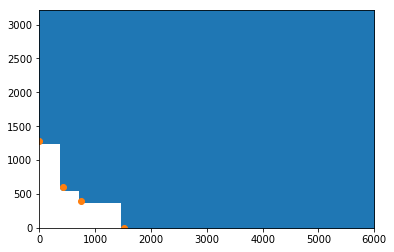

In [104]:
items = [(0, 0, 0, False), (10, 0, 0, False), (2, 0, 0, False), (3, 0, 0, True)]

locations2 = []
for x in range(0, widthPlates, 20):
    for y in range(0, heightPlates, 20):
        if cond_etoile_verte(items, (5, x, y, True), batch_mat):
            locations2.append((x, y))
            
locations = locations_etoile_verte_deprecated(items, 5, True, batch_mat)
plt.scatter([x[0] for x in locations2], [x[1] for x in locations2])
plt.scatter([x[0] for x in locations], [x[1] for x in locations])
plt.xlim([0, widthPlates])
plt.ylim([0, heightPlates])
plt.show()

### Nouvelle fonction

Étant donnée que l'*étoile verte* est définie par un nombre fini d'items : ce sont *davantage* les derniers items qui la définissent. Il s'agit plus précisemment d'une enveloppe d'items (nommée `hull` dans les fonctions). Afin de simplifier l'algorithmie, cette enveloppe correspond à une liste de points `(x, y)` triée selon `x`.

Ainsi la nouvelle fonction possède deux étapes :
* Dans un premier temps, il s'agit d'*incrémenter l'étoile verte* : si `hull` est une enveloppe, il s'agit de calculer la nouvelle enveloppe qui contienne une position supplémentaire. 
* Dans un deuxième temps, il s'agit de savoir si une position est inclue ou non dans l'enveloppe : il suffit de parcourir l'enveloppe (une dichotomie pourrait être envisagée mais comme l'enveloppe est de toute petite taille, il est plus intéressant de faire un parcours ± exhaustif).

In [1]:
def incr_etoile_verte(hull, pos):
    """
        hull = [(x, y)] sorted by x inc. and y dec.
        pos = (X, Y) (corresponds to (x + w, y + h))
        RAJOUTER ICI L'INCRÉMENTATION DES DÉFAUTS
    """
    (X, Y) = pos
    k = 0
    while k < len(hull):
        (x, y) = hull[k]
        if x == X:
            del hull[k]
            continue
        
        if x > X:
            break
            
        if y < Y:
            del hull[k]
            continue
            
        k += 1    
    
    hull.insert(k, (X, Y))
    return hull  

In [3]:
incr_etoile_verte(hull, (1, 1))

[(1, 1), (10, 10)]

In [106]:
def incr_etoile_verte_copy(hull, x, y, w, h, rotated):
    hull_c = copy(hull)
    if rotated:
        incr_etoile_verte(hull_c, (x + h, y + w))
    else:
        incr_etoile_verte(hull_c, (x + w, y + h))
    return hull_c

On dispose enfin de tous les élements pour renvoyer la liste des emplacements qui vérifient la condition de l'étoile verte.

In [107]:
%%cython
cimport numpy as np
from copy import copy
from __main__ import width_item, height_item 

cpdef list locations_etoile_verte(list hull, int item, np.ndarray batch_mat, widthPlates, heightPlates):
    """
        Renvoie toutes les positions qui vérifient la condition de l'étoile verte
        ATTENTION, NE VÉRIFIE PAS QUE LA POSITION (0, 0) EST VALIDE
    """
    cdef int w = width_item(item, False, batch_mat)# maybe widthNode...
    cdef int h = height_item(item, False, batch_mat)
    
    cdef int x_max_rot = widthPlates - h 
    cdef int y_max_rot = heightPlates - w
    cdef int x_max = widthPlates - w
    cdef int y_max = heightPlates - h
    
    cdef list locations = [copy(hull) for x in range(2)] #locations[0] => rotated = false
    
    cdef int x
    cdef int y
    cdef int n = len(hull)
    cdef int k
    
    if n > 0: # la longueur de l'enveloppe
        
        (x, y) = (0, hull[0][1])
        if y <= y_max:
            locations[0].append((x, y))
        
        if y <= y_max_rot:
            locations[1].append((x, y))
            
        k = 0
        while k < n - 1 and x < x_max:
            (x, y) = (hull[k][0], hull[k + 1][1])
            if y < y_max:
                locations[0].append((x, y))
            
            if y < y_max_rot:
                locations[1].append((x, y))
                
            k += 1
        
        (x, y) = (hull[-1][0], 0)
        if x <= x_max:
            locations[0].append((x, y))
            
        if x <= x_max_rot:
            locations[1].append((x, y))
        
        return locations
    else:
        # ne vérifie pas que c'est valide ici
        return [[(0, 0)], [(0, 0)]]

Le temps est raisonnable, pour une instance toute petite :
> 1.81 µs ± 43 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)

## La gestion des défauts

On dispose de deux fonctions : 
* Tout d'abord, on regarde si un défaut est inclus ou non dans une pièce. Il faut remarquer que cette fonction ne fonctionne pas dans un cas général : les défauts dans `defs_included` correspondent à un sous-ensemble de défauts susceptibles d'être inclus.
* Une deuxième fonction permet de renvoyer, pour une pièce, une position et une orientation données, quels sont emplacements libres de défauts. De plus cette fonction se charge de vérifier la contrainte d'inclusion (pour faire en sorte que la pièce ne dépasse pas).
 * Si l'emplacement est possible et libre de défaut, on renvoie la position
 * Si l'emplacement contient plusieurs défauts, on détermine les nouveaux emplacements possibles (en s'inspirant de l'ancienne fonction de la condition de l'étoile verte − définie plus loin) et on applique récursivement la fonction à chacun de ces emplacements.

In [108]:
%%cython
cpdef int loc_not_included_defects(list defs_included, int X, int Y):
    
    cdef int i = 0
    
    while i < len(defs_included) and\
        (defs_included[0][1] + defs_included[0][3] <= X or\
        defs_included[0][2] + defs_included[0][4] <= Y):
        i += 1
        
    return not(i < len(defs_included))    

In [109]:
from functools import reduce

def locs_free_of_defects(bin_id, X, Y, W, H, x_max, y_max, list_def):

    # 1ère étape = détecter les positions des défauts qui mangent
    IMIN = 0
    i = IMIN
    IMAX = len(list_def[bin_id]["x"][:, 2])
    x = X
    defects_included = []
    
    XW = X + W
    YH = Y + H
    
    if X > x_max or Y > y_max:
        return []
    
    while i < IMAX and x < XW:
        [k, x, y, w, h] = list_def[bin_id]["x"][i, [0, 2, 3, 4, 5]]

        if X <= x and x + w < XW and Y <= y and y < YH:
            defects_included.append((k, x, y, w, h))

        if x > XW:
            IMAX = i

        if x < X:
            IMIN += 1

        i += 1
    
    #print(i, imax, x, x_max, y, y_max)
    #print("Lg def : ", len(defects_included), IMIN, IMAX)
    
    if len(defects_included) == 0:
        return [(X, Y)]
    
    # 2ème étape = pour ces points là, appliquer l'ancien algorithme de l'étoile verte
    XX =sorted([X] + [list_def[bin_id]["x"][i, 2] 
               + list_def[bin_id]["x"][i, 4] for i in range(IMIN, IMAX)])
    YY = sorted([Y] + [list_def[bin_id]["x"][i, 3] 
               + list_def[bin_id]["x"][i, 5] for i in range(IMIN, IMAX)])
    #print(XX, YY)
    locations = []
    i = 0
    j = 0
    jmax = len(YY)
    imax = len(XX)
    #print("imax", imax, jmax)
    while i < imax and j < jmax:
        x = XX[i]
        y = YY[j]
        #print(x, y)
        if x > x_max:
            imax = i
            continue
        if y > y_max:
            jmax = j
            j = 0
            i += 1
            continue

    if loc_not_included_defects(defects_included, x, y):
        locations.append((x, y))        
        jmax = j
        j = 0
        i += 1
    else:
        j += 1
    if j == jmax:
        i += 1
        j = 0

    #print("loc", locations)
    if len(locations) > 0:        
        return reduce(lambda x, y: x + y, 
                  [locs_free_of_defects(bin_id, x, y, W, H, x_max, y_max, list_def) for (x, y) in locations])
    return []

In [110]:

def nb_defects_in_etoile_verte(list_def_bin, hull):
    n = 0
    if len(hull) == 0:
        return 0
    
    if len(list_def_bin["x"]) == 0:
        return 0
    
    k_def = 0
    k_hull = 0
    
    y_st = hull[k_hull][1]
    x_st = hull[k_hull][0]

    [_, _, x_def, y_def, w_def, h_def] = list_def_bin["x"][k_def]
    x_def += w_def
    y_def += h_def

    while k_def < len(list_def_bin["x"][:, 0]) and k_hull < len(hull):

        if x_def <= x_st:
            if y_def <= y_st:
                n += 1

            k_def += 1
            if k_def < len(list_def_bin["x"][:, 0]):
                [_, _, x_def, y_def, w_def, h_def] = list_def_bin["x"][k_def]
                x_def += w_def
                y_def += h_def

        else:
            k_hull += 1
            if k_hull < len(hull):
                y_st = hull[k_hull][1]
                x_st = hull[k_hull][0]
    return n

### Combinaison des deux
On peut désormais calculer les emplacements qui vérifient les conditions de l'étoile verte et en déduire ceux qui vérifient à la fois la condition de l'étoile verte et celle du *monstre rouge*.

In [111]:
def locations_etoile_verte_and_free_of_defects(bin_id, hull, item, batch_mat,
                                                widthPlates, heightPlates, list_defects):
    
    
    loc = locations_etoile_verte(hull, item, batch_mat, widthPlates, heightPlates)
    
    (W, H) = width_height_mat(item, False, batch_mat)
    if len(loc[0]) > 0:
        loc[0] = reduce(lambda x, y: x + y,
                        [locs_free_of_defects(bin_id, x, y, W, H, widthPlates - W, heightPlates - H, list_defects)
                       for (x, y) in loc[0]])
    
    if len(loc[1]) > 0:
        loc[1] = reduce(lambda x, y: x + y,
                        [locs_free_of_defects(bin_id, x, y, H, W, widthPlates - H, heightPlates - W, list_defects)
                       for (x, y) in loc[1]])
    #print("loc", item, loc)
    return loc
    

# Séquence −> arbre admissible
Disposant de tous les éléments précédents, il est envisageable de tenter de placer une séquence admissible donnée, obtenue aléatoirement : on pourrait alors construire plusieurs séquences possibles.

Mine de rien, c'est déjà pas mal du tout d'obtenir un tel algorithme et plutôt prometteur pour la suite.

In [112]:
def place_sequence(sequence):
    bin_id = 0
    # selection de l'item à placer

    items_cut = [[] for x in range(100)] # liste d'items par bin (k, x, y, rotated)
    trees = [[] for x in range(100)]
    hulls = [[] for x in range(100)]

    k = 0
    while k < len(sequence) and bin_id < 100:
        node = [0, 0, widthPlates, heightPlates, 0, [], -2]
        item = sequence[k]
        rotated = None
        (w, h) = width_height_mat(item, False, batch_mat)
        # Liste des positions possibles, triées par de la "meilleure" 
        # à la "pire" −> réussir à donner un tel sens
        # un emplacement doit vérifier :
        # 1 / la condition de l'étoile verte
        # 2 / l'évitement des défauts
        # [(xk, yk)]
        locations = locations_etoile_verte_and_free_of_defects(bin_id, hulls[bin_id], item, batch_mat,
                                                widthPlates, heightPlates, list_def)

        
        #print(item, locations)
        if len(locations[0]) == 0:
            rotated = True
        elif len(locations[1]) == 0:
            rotated = False
        else:
            rotated = randint(0, 1) == 1
       
        i = 0 
        while i < len(locations[rotated]):
            (x, y) = locations[rotated][i]
            
            # pour chaque emplacement, creation d'un arbre admissible
            try:
                trees[bin_id] = gen_tree(node, items_cut[bin_id] + [(item, x, y, rotated)])
                items_cut[bin_id].append((item, x, y, rotated))
                
                if rotated:
                    incr_etoile_verte(hulls[bin_id], (x + h, y + w))
                else:
                    incr_etoile_verte(hulls[bin_id], (x + w, y + h))
                break
            except Exception as error:
                #print(error)
                node = [0, 0, widthPlates, heightPlates, 0, [], -2]
            i += 1
    
        if i == len(locations[rotated]):
            k -= 1
            bin_id += 1
        
        k += 1
    
    return (trees, items_cut)

#### Premier test qui vérifie toutes les contraintes

In [113]:
(trees, items_cut) = place_sequence(random_seq(stacks))
draw_trees(trees)

KeyboardInterrupt: 

#### Calcul du coût défini dans l'énoncé de la ROADEF

In [ ]:
def cost_roadef(items_cut):
    s = 0
    n = len([i for i in range(len(items_cut)) if len(items_cut[i]) > 0])
    for bin_id in range(n):
        for it in items_cut[bin_id]:
            s += width_item(int(it[0]), True, batch_mat)*height_item(int(it[0]), True, batch_mat)
        
    list_residuals = [item[1] + width_item(item[0], item[3], batch_mat) for item in items_cut[n - 1]]
    # Normalement, ça ne devrait pas arriver…
    if len(list_residuals) == 0:
        return 0
    
    return ((n - 1)*widthPlates + max(list_residuals))*heightPlates - s

#### Résolution aléatoire
Dans un cas très réduit, juste pour simuler en tirant au sort des séquences

In [ ]:
def test_alea(n = 500):
    best_score = np.inf
    best_trees = None
    best_seq = []
    best_items_cuts = []

    for k in range(n):
        seq = random_seq(stacks)
        (trees, items_cut) = place_sequence(seq)
        score = cost_roadef(items_cut)
        if score < best_score:
            best_score = score
            best_trees = trees
            best_seq = seq
            best_items_cuts = items_cut
            print("Current best score : ", score)
    draw_trees(best_trees)
    return (best_seq, best_trees, best_items_cuts)
(seq, trees, items_cut)= test_alea(500)

In [ ]:
cost_roadef(items_cut)

Il y a un bug étrange avec le coût de la ROADEF qui vaut parfois 0, étant donné qu'une liste n'est pas calculée. En tout cas, on vérifie que l'algorithme fonctionne mais que les résultats ne sont pas très positifs.

# Algorithme glouton (et aléatoire)

**Objectif** : disposer de (très) bonnes solutions sur une base gloutonne (sans trop de backtracking :p, du moins pour le moment) mais que ces solutions disposent d'une partie aléatoire afin de pouvoir en tester plusieurs (*plus tard*). 

La partie aléatoire viendrait d'une composante du score.

**NB.** Pour le moment, deux contraintes ne sont pas encore implémentées :
* Taille des déchets $> 20×20$
* Pas de coup sur des déchets

**Idée générale de l'algorithme**
 > Tant que des pièces sont disponibles:
 >>Calculer pour toutes les pièces possibles (une par stack) et toutes leurs positions / orientations un score (> 100 par étape...)
 >> Appliquer la transformation avec avec la *meilleure pièce* placée au *bon* endroit et *bien orientée*.
 
 > Et ça marche !
 
**Quelques pistes pour accélerer le calcul** :
* Il semblerait que le résultat soit meilleur pour les premières positions (pas forcément LA première) (mais 1, 2 ou 3…)
* Certaines pièces peuvent ne pas être meilleures (quoi que avec la présence des défauts)

**Quelques pistes pour notre *score***:
* On veut minimiser l'espace perdu (*aire de l'étoile verte*)
* S'il y a un défaut, elle n'est pas vraiment perdue… Peut-être considérer que $20\times20$ par défaut ne sont pas perdus ?
* Est-ce qu'on ne considérerait pas des rectangles ?

## Le score

#### Fonction de calcul de surface *étoile verte*

In [ ]:
%%cython

cpdef int area_etoile_verte(list hull):
    cdef int n = len(hull)
    cdef int k = 0
    cdef int area = 0
    if n > 0:
        area = hull[0][0]*hull[0][1]

        while k < n - 1:
            area += (hull[k + 1][0] - hull[k][0])*hull[k + 1][1]
            k += 1
    return area

On a eu un eu un **facteur > 4** avec le passage en `Cython` et le typage des variables.

Codons une fonction de score associée à cette surface, elle est à optimiser car je n'aime pas du tout faire une telle copie :'(

In [ ]:
from copy import deepcopy

def score_etoile_verte(hull, pos, previous_score, list_def_bin):
    hull_c = deepcopy(hull)
    #n = nb_defects_in_etoile_verte(list_def_bin, hull_c) - nb_defects_in_etoile_verte(list_def_bin, hull)
    #print(hull_c)
    incr_etoile_verte(hull_c, pos)
    return (len(hull_c),
            area_etoile_verte(hull_c) - previous_score,
            nb_defects_in_etoile_verte(list_def_bin, hull_c) - nb_defects_in_etoile_verte(list_def_bin, hull))
    

**Implémentation** du score :
* $\lambda.x$ pour favoriser les pièces sur $x$
* enlever dans le score l'aire du rectangle courant (car du coup ce n'est pas perdu :))

In [ ]:
from random import random
from copy import deepcopy

def score(hull, loc, sc, area, list_def_bin, 
          weight_x = 1000, weight_y = 100, 
          weight_area = 4, weight_size_hull = 100, 
          weight_nb_defects = 10, weight_random = 10):
    (x, y) = loc
    (n, scev, nb_new_defects) = score_etoile_verte(hull, (x, y), sc, list_def_bin)

    return scev + weight_x*x - weight_y*y - weight_area*area\
            + weight_size_hull*n - weight_nb_defects*nb_new_defects\
            + weight_random*random()\
            - λ*max(0, y - 2900)\
            + μ*max(0, x - 6700)\

## LE glouton

In [ ]:
def glouton_aleatoire(stacks, list_def, params):
   
    for s in stacks:
        s.reset()
    (x, y) = (-1, -1)
    items_cut = [[] for x in range(100)] # liste d'items par bin (k, x, y, rotated)
    sequence = []
    trees = [[] for x in range(100)]
    hulls = [[] for x in range(100)]

    n = sum([s.n for s in stacks])

    # stacks_available = LISTE des stacks non vide (car on veut tous les parcourir)
    for s in stacks:
        s.reset()
        
    stacks_available = [i for i in range(len(stacks)) if not stacks[i].is_empty()]
    bin_id = 0
    k = 0
    max_score = np.inf
    # Tant que des items sont à placer
    previous_score = 0
    iter = 0
    while len(stacks_available) > 0 and iter < 5000000:
        best_score = max_score
        best = (-1, x, y, False) # (i_stack, (x, y), rotated) (aucun sens si best_score môvais)
        # On regarde tous les items disponibles
        for s in stacks_available:
            item = stacks[s].top()

            (w, h) = width_height_mat(item, False, batch_mat)
            locations = locations_etoile_verte_and_free_of_defects(bin_id, hulls[bin_id], item, batch_mat,
                                                    widthPlates, heightPlates, list_def)
            if item == 44 and len(sequence) > 0 and sequence[-1] == 11:
                print(sequence[-1], locations)
                pass
            for rotated in (False, True):
                for (x, y) in locations[rotated]:
                    try:
                        node = [0, 0, widthPlates, heightPlates, 0, [], -2]
                        iter += 1
                        gen_tree(node, items_cut[bin_id] + [(item, x, y, rotated)])
                        current_score = max_score
                        if rotated:
                            current_score = score(hulls[bin_id], 
                                                  (x + h, y + w),
                                                  previous_score, h*w, 
                                                  list_def[bin_id], *params)
                        else:
                            current_score = score(hulls[bin_id],
                                                  (x + w, y + h), 
                                                  previous_score, h*w,
                                                  list_def[bin_id], *params)
                    
                        if current_score <= best_score:
                            best_score = current_score
                            best = (s, x, y, rotated)
                        
                            #print(best)

                    except Exception as error:
                        #print(bin_id, item, x, y, w, h, rotated)
                        #if item == 44:
                        #    print(error)
                        pass
        # Soit aucun item ne tient et alors on passe sur une nouvelle bin
        if best_score == np.inf:
            bin_id += 1
            if bin_id >= 100:
                break
        # Soit il y en a un et alors on le place, on met à jour l'étoile verte etc.
        else:
            previous_score += best_score
            (s, x, y, rotated) = best
            item = stacks[s].pop()
            if stacks[s].is_empty():
                del stacks_available[stacks_available.index(s)]

            (w, h) = width_height_mat(item, False, batch_mat)
            if rotated:
                incr_etoile_verte(hulls[bin_id], (x + h, y + w))
            else:
                incr_etoile_verte(hulls[bin_id], (x + w, y + h))
            sequence.append(item)
            items_cut[bin_id].append((item, x, y, rotated))

            node = [0, 0, widthPlates, heightPlates, 0, [], -2]
            
    return (items_cut, trees)

La fonction de score utilisée permet d'obtenir de très bons (d'excellents !) résultats avec un taux d'utilisation maximal et moyen atteint de $74\%$ pour l'instance `A8`. Toutefois, on remarque que cela dépend très fortement des paramètres utilisés dans la fonction de score (λ, β, δ, γ, α…) et que de plus le résultat **dépend fortement de la plaque**. 

On pourrait ainsi imaginer d'optimiser ces paramètres sur chaque plaque. En effet, une optimisation sur chaque plaque devrait être *à peu près* équivalent à une optimisation globale étant donné la contrainte d'ordre.

In [ ]:
name = "A0"

best_score = 10000000000000
(defects, batch, batch_mat, stacks, list_def) = load_complete_instance(name)
best_ẗems = None

# dans l'ordre weight_x, weight_y, weight_area, weight_size_hull, weight_nb_defects, weight_random
# de bons paramètres [1000, 10, 2, 900000,0, 0] params = [1000, 10, 2, 900000, 200000, 0]
# params = [1000, 10, 2, 900000, 200000, 0]
# params = [1000, 10,2.2,900000, 200000, 0]
params = [1000, 10,2.2,900000, 200000, 0]
#params = [1000, 100, 9, 90, 2500, 0]
μ = 5
000
λ = 1000
for k in range(1):
    (items_cut, trees) = glouton_aleatoire(stacks, list_def, params)
    sc = cost_roadef(items_cut)
    if sc <= best_score:
        print(sc)
        best_score = sc
        best_items = items_cut
        
for i in range(sum([1 for i in range(len(items_cut)) if len(items_cut[i]) > 0])):
        node = [0, 0, widthPlates, heightPlates, 0, [], -2]
        trees[i] = gen_tree(node, items_cut[i])
        
def to_residual(node):
    if len(node[5]) == 0:
        node[6] = -3
    else:
        to_residual(node[5][-1])

def make_residual_trees(trees):
    n = sum([len(tree) for tree in trees])//7
    to_residual(trees[n - 1])
make_residual_trees(trees)


trees_to_file(name, trees)
trees_to_file(name + "_" + str(cost_roadef(items_cut)), trees)
draw_trees(trees)

In [ ]:
print(batch_mat[44, :])
print(batch_mat[112, :])

In [ ]:
items_cut[5]

In [ ]:
X.insert(4, (44, 1662, 2095, True))

In [ ]:
t = gen_tree([0, 0, widthPlates, heightPlates, 0, [], -2], X)
draw_tree(t, 1)
plt.show()


## Optimisation sur un jumbo

In [ ]:
def optim_un_jumbo(states, max_iter, bin_id, list_def_bin):

    node = [0, 0, widthPlates, heightPlates, 0, [], -2]
    items_cut_bin = [] # liste d'items par bin (k, x, y, rotated)
    sequence = []
    trees = []
    hull = []


    # boucle de recherche locale, on ne garde que le meilleur résultat
    params = [1000, 8, 2.2,900000, 200000, 0]
    currents_params = params
    # dans l'ordre weight_x, weight_y, weight_area, weight_size_hull, weight_nb_defects, weight_random
    Δx = [1, 1, 1, 1000, 1000, 1]

    # Distribution de probabilité (à normaliser pour obtenir la distribution)
    π = np.array([50, 2, 2, 2, 1, 0.3])
    π /= sum(π)


    best_cost = np.inf
    (best_items_cut_bin, best_tree) = ([], [])

    current_iter = 0

    while current_iter < max_iter:

        # RECHERCHE LOCALE SUR LES PARAMÈTRES DE LA FONCTION DE SCORE
        p = randint(0, len(params) - 1)
        currents_params[p] += (2*(random() < 0.5) - 1)*Δx[p]   
        #print(params, currents_params, p)

        # On réinitialise les stacks
        for k in range(len(stacks)):
            stacks[k].reset(begin = states[k])

        stacks_available = [i for i in range(len(stacks)) if not stacks[i].is_empty()]

        uncomplete = True # vaut Faux dès qu'il n'y a plus de place sur le bin courant
        k = 0
        max_score = np.inf
        # Tant que des items sont à placer    
        # On tente de placer les items
        previous_score = 0
        sub_iter = 0
        while len(stacks_available) > 0 and uncomplete and sub_iter < 50000:

            best_score = max_score
            best = (-1, 0, 0, False) # (i_stack, (x, y), rotated) (aucun sens si best_score môvais)
            # On regarde tous les items disponibles
            for s in stacks_available:
                item = stacks[s].top()

                (w, h) = width_height_mat(item, False, batch_mat)
                locations = locations_etoile_verte_and_free_of_defects(bin_id, hull, item, batch_mat,
                                                        widthPlates, heightPlates, list_def)
                for rotated in (False, True):
                    for (x, y) in locations[rotated]:
                        try:
                            node = [0, 0, widthPlates, heightPlates, 0, [], -2]
                            sub_iter += 1
                            tree = gen_tree(node, items_cut_bin + [(item, x, y, rotated)])
                            current_score = max_score
                            if rotated:
                                current_score = score(hull, 
                                                      (x + h, y + w),
                                                      previous_score, h*w, 
                                                      list_def_bin, *currents_params)
                            else:
                                current_score = score(hull,
                                                      (x + w, y + h), 
                                                      previous_score, h*w,
                                                      list_def_bin, *currents_params)
                            #print(current_score)
                            if current_score <= best_score:
                                best_score = current_score
                                best = (s, x, y, rotated)

                                #print(best)

                        except Exception as error:
                            #print(bin_id, item, x, y, w, h, rotated)
                            #print(error)
                            pass
            # Soit aucun item ne tient et alors on passe sur une nouvelle bin
            if best_score == np.inf:
                uncomplete = False
            # Soit il y en a un et alors on le place, on met à jour l'étoile verte etc.
            else:
                previous_score += best_score
                (s, x, y, rotated) = best
                item = stacks[s].pop()
                if stacks[s].is_empty():
                    del stacks_available[stacks_available.index(s)]

                (w, h) = width_height_mat(item, False, batch_mat)
                if rotated:
                    incr_etoile_verte(hull, (x + h, y + w))
                else:
                    incr_etoile_verte(hull, (x + w, y + h))
                sequence.append(item)
                items_cut_bin.append((item, x, y, rotated))

                node = [0, 0, widthPlates, heightPlates, 0, [], -2]

        current_iter += 1
        if len(stacks_available) > 0: # ce n'est pas la dernière bin
            current_cost = widthPlates*heightPlates
        else:
            current_cost = heightPlates*max([item[1] + width_item(item[0], item[3], batch_mat) for item in items_cut_bin])

        current_cost -= sum([width_item(int(it[0]), True, batch_mat)*height_item(int(it[0]), True, batch_mat) for it in items_cut_bin])

        #print(currents_params)
        if current_cost < best_cost:
            best_cost = current_cost
            best_items_cut = items_cut
            best_tree = tree
            params = currents_params
            rate = sum([width_item(int(it[0]), True, batch_mat)*height_item(int(it[0]), True, batch_mat) for it in items_cut_bin])/(sum([width_item(int(it[0]), True, batch_mat)*height_item(int(it[0]), True, batch_mat) for it in items_cut_bin]) + current_cost)
            print(best_cost)
            print(rate)
    
    return (best_cost, rate, params, best_items_cut_bin)

In [ ]:
states = [s.begin for s in stacks]
max_iter = 100
bin_id = 0
list_def_bin= list_def[bin_id]

(best_cost, rate, best_params, best_items_cut_bin) = optim_un_jumbo(states, max_iter, bin_id, list_def_bin)

Si on place les items totalement aléatoirement (partie aléatoire dominante dans la fonction de score), les taux obtenus sont très très môvais : le meilleur résultat atteint sur $100 000$ itérations, ce qui est très lent (plusieurs minutes de calcul) est seulement de $57\%$. De plus, cette solution a été obtenue en très peu d'itérations (de l'ordre d'une centaine … !).

On remarque également que :
* soit le poids de la partie aléatoire est négligeable et alors la solution optimale est inchangée
* soit elle est influe sur le résultat mais cette influence semble être toujours négative (soit une perte de l'ordre de 2%, soit de plus de 40% !

Il faut donc chercher la solution ailleurs.

In [ ]:
draw_tree(gen_tree(node, items_cut_bin), 0)
plt.show()

In [ ]:
items_cut = [[] for x in range(100)] # liste d'items par bin (k, x, y, rotated)
sequence = []
trees = [[] for x in range(100)]
hulls = [[] for x in range(100)]

for s in stacks:
    s.reset()

stacks_available = [i for i in range(len(stacks)) if not stacks[i].is_empty()]

while len(stacks_available) < 0:
    
states = [s.begin for s in stacks]
max_iter = 100
bin_id = 0
list_def_bin= list_def[bin_id]

(best_cost, rate, best_params, best_items_cut_bin) = optim_un_jumbo(states, max_iter, bin_id, list_def_bin)

In [ ]:
batch_mat[119, :]

In [ ]:
(batch_mat[40,:], batch_mat[20, :], batch_mat[21, :], batch_mat[119, :])

In [ ]:
1321 + 826 + 1134 + 350

# Résolution d'un problème relâché
On relâche de nombreuses contraintes :
* La contrainte d'ordre : tous les items peuvent être placés dans n'importe quel ordre
* La contrainte de guillotine cut : les coupes peuvent être plus collées 
* La gestion des défauts

?? Je ne suis pas sûr de la pertinence

# Résolution exhaustive

La fonction glouton aléatoire n'optimise que sur un seul triplet (pièce, emplacement, rotation) et fournit déjà de bons résultats. Toutefois, des *trous* subsistent, dans lesquels il serait intéressant de mettre des pièces.

Afin de limiter ces trous, l'idée serait de réaliser une recherche exhaustive sur l'arbre des solutions, constitué des triplets (pièce, emplacement, rotation). Malheureusement, cela semble impossible combinatoirement, notamment parce que je ne pense pas disposer (surtout maintenant) facilement de bonnes bornes afin de réaliser un algorithme de *branch and bound*.

Par contre,je ne pense pas qu'il soit nécessaire de descendre trop profondemment dans l'arbre : une profondeur de 2 ou 3 devait être suffisante pour d'une part obtenir de bons résultats, et d'autre part conserver une complexité réduite (la complexité demeure polynomiale, de degré la profondeur étudiée).

Algorithmiquement, il s'agit de construire une fonction récursive pour réaliser cette recherche exhaustive, pour une profondeur donnée.

L'algorithme en pseudo-code, actuellement utilisé dans la fonction `glouton aléatoire` (qui porte très mal son nom).

>```
Pour chaque stack disponible
    Calculer les emplacements disponibles
        Pour chaque rotation 
            Essayer de construire un arbre
            Si c'est possible, calculer le score
            Sinon, mettre le score à inf
Renvoyer le meilleur triplet (pièce, emplacement, rotation)
```

L'algorithme, en pseudo code, pour faire une recherche exhaustive, sans optimisation

```
function score_recursif(stacks, stacks_available, hull, items_cuts, profondeur):
    Initialiser meilleur_score à inf
    Initialiser meilleur_triplet
    
    Si des triplets sont disponibles ou si la profondeur maximale n'est pas atteinte
        Pour chaque triplet (pièce, emplacement, rotation) possible    
            Rajouter à items cut le triplet courant
            Mettre à jour stacks_available
            Mettre à jour hull
            Calculer le score de score_recursif(stacks, stacs_available, hull, items_cuts, profondeur)
            Si ce score est inférieur à meilleur score
                Mettre à jour meilleur_score et meilleur_triplet                
            Réinitialiser hull, stacks_available, items_cut
       
       Rajouter à items_cut le meilleur triplet et mettre à jour hull et stacks_available
       Renvoyer les meilleures solutions actuelles (triplet et score)
    Sinon
        Calculer et renvoyer le score de la solution courante ainsi que le triplet vide
```

La fonction ci-dessous calcule un **score courant** qui correspond, en gros, au taux d'occupation (= le score de la ROADEF), la difficulté étant de déterminer ce qui est réellement perdu : est-ce que tout ce qui est avantle $x_\text{max}$ est perdu ? Pas vraiment quand même (et heureusement !).

Grosse difficulté liée à l'usage de **Python** : comment gérer les modifications en place des objets et des listes (notamment des stacks) qui imposent de retirer les éléments rajoutés (ou de faire des copies).

In [ ]:
from copy import copy

Cette fonction enlève un élément du stack d'index `s` et retire l'index s de la liste `stacks_available` si la liste est alors vidée. 

In [ ]:
def remove_stacks_available(stacks, stacks_available, s):
    item = stacks[s].pop()
    if stacks[s].is_empty():
        del stacks_available[stacks_available.index(s)]
    return item

In [ ]:
def add_stacks_available(stacks, stacks_available, s):
    if stacks[s].is_empty():
        stacks_available.append(s)
    stacks[s].push()

Le score n'est pas encore fait, il est directement celui de la ROADEF là. On veut réaliser plusieurs choses avec ce score

In [ ]:
weight_x = 1000
weight_area = 3
weight_hull = 9000000
weight_defects = 200000

def score_depth_search(items_cuts_bin, end, hull, list_def_bin):
    """
    On souhaite le minimiser 
    """
    #print(items_cuts_bin)
    if len(items_cuts_bin) == 0:
        return 0
    
    # surface occupée
    s = sum([width_item(int(it[032.]), True, batch_mat)*height_item(int(it[0]), True, batch_mat) for it in items_cuts_bin])
    
    # le plus grand x
    xmax = max([item[1] + width_item(item[0], item[3], batch_mat) for item in items_cuts_bin])
    
    # l'aire de l'etoile verte
    area = area_etoile_verte(hull)
    
    # la taille de l'étoile verte
    size_hull = len(hull)
    
    # le nombre de défauts dans l'étoile verte 
    nb_defects = nb_defects_in_etoile_verte(list_def_bin, hull)
    #print(weight_x*xmax - weight_area*s + weight_hull*size_hull - weight_defects*nb_defects)
    return weight_x*xmax - weight_area*s + weight_hull*size_hull - weight_defects*nb_defects 
    

In [ ]:
score_depth_search(items_cut[0], True, [], list_def[0])

In [ ]:
stacks_available = [k for k in range(len(stacks)) if not stacks[k].is_empty()]

In [ ]:
for s in stacks:
    s.reset()

In [ ]:
def depth_search(stacks, stacks_available, hull_bin, items_cuts_bin, current_depth,
                bin_id, widthPlates, heightPlates, verbose = False):
    """
    * items_cuts_bin = la liste courante des items (de même pour hull)
    * items_cuts = la liste des items PLACÉS
    """
    it = [(0, 0, 0, False),(1, 0, 1578, True),(2, 758, 0, True),(3, 758, 276, True),(4, 758, 1672, False)]
    #print("HHHH")
    #print(hull_bin)
    # Aucun triplet n'est disponible ou la profondeur maximale a été atteinte
    if current_depth == 0 or len(stacks_available) == 0:
        #print(score_depth_search(items_cuts_bin, True, hull_bin, list_def[bin_id]))
        return ([], score_depth_search(items_cuts_bin, True, hull_bin, list_def[bin_id])) # on peut partir là dessus…
    
    best_score = np.inf
    best = []
    # La recherche continue
    for s in stacks_available:
        item = stacks[s].top()
        
        # On enlève l'élément du stack s et on met à jour (éventuellement) stacks_available
        remove_stacks_available(stacks, stacks_available, s)
        
        (w, h) = width_height_mat(item, False, batch_mat)
        locations = locations_etoile_verte_and_free_of_defects(bin_id, hull_bin, item, batch_mat,
                                                               widthPlates, heightPlates, list_def)
        #print("HKX")
        #print(hull_bin)
        if len(items_cuts_bin) > 0 and items_cuts_bin[-1] == (3, 758, 276, True):
            print("a")
            print(items_cuts_bin, hull_bin, locations)
        for rotated in (False, True):
            for (x, y) in locations[rotated]:
                
                try:
                    if (item, x, y, rotated) == (4, 738, 1672, False):
                        print(items_cuts_bin + [(item, x, y, rotated)])
                        print("OOOo")
                    tree = gen_tree([0, 0, widthPlates, heightPlates, 0, [], -2], items_cuts_bin + [(item, x, y, rotated)])

                    if (item, x, y, rotated) == (4, 738, 1672, False):
                        print(items_cuts_bin + [(item, x, y, rotated)])
                        
                    #print("-------")
                    #print(items_cuts_bin)
                    #print("*****")
                    #print(hull_bin, incr_etoile_verte_copy(hull_bin, x, y, w, h, rotated))
                    #print("-------")
                    (current_cut, current_score) = depth_search(stacks, stacks_available, 
                                                 incr_etoile_verte_copy(hull_bin, x, y, w, h, rotated),
                                                 items_cuts_bin + [(item, x, y, rotated)],
                                                 current_depth - 1,
                                                 bin_id, widthPlates, heightPlates, verbose = False)
                    
                    if current_score <= best_score:
                        best_score = current_score
                        best = [(s, x, y, rotated)] + current_cut
                                                
                except Exception as error:
                    if verbose:
                        print((s, x, y, rotated), error)
                        
        # On remet l'élément dans le stack s             
        add_stacks_available(stacks, stacks_available, s)
        
    # Si aucun emplacement triplet ne tient sur le jumbo
    if best_score == np.inf:
        if bin_id >= 100:
            return ([], -1) # Il n'y a pas assez de jumbos pour résoudre l'instance
        return (best, best_score)
    
    # Il y a au moins un emplacement valide
        
    # On rajoute l'élément
    #print(best_score, best)
    #print(items_cuts_bin)
    return (best, best_score)

    

In [115]:
name = "A1"

(defects, batch, batch_mat, stacks, list_def) = load_complete_instance(name)
    
max_depth = 20
stacks_available = [k for k in range(len(stacks)) if not stacks[k].is_empty()]
items_cut = [[] for x in range(100)] # liste d'items par bin (k, x, y, rotated)
sequence = []
trees = [[] for x in range(100)]
hulls = [[] for x in range(100)]
bin_id = 0

max_iter = 300000
current_iter = 0
weight_x = 80000000#8000
weight_area = 0#4
weight_hull = 0#1000000
weight_defects = 0#2000
while len(stacks_available) > 0 and current_iter < max_iter:
    (stacks_cut, score) = depth_search(stacks, stacks_available, hulls[bin_id], 
                                       items_cut[bin_id], max_depth, bin_id, widthPlates, heightPlates)
    #print("=========")
    #print(hulls[bin_id])
    #print("=========")
    if len(stacks_cut) == 0:
        bin_id += 1
        continue

    (s, x, y, rotated)= stacks_cut[0]
    item = remove_stacks_available(stacks, stacks_available, s)
    (w, h) = width_height_mat(item, rotated, batch_mat)
    incr_etoile_verte(hulls[bin_id], (x + w, y + h))
    items_cut[bin_id].append((item, x, y, rotated))
    if current_iter % 30 == 0:
        #print(current_iter)
        pass
    current_iter += 1

trees = [gen_tree([0, 0, widthPlates, heightPlates, 0, [], -2], it) for it in items_cut if len(it) > 0]
print(cost_roadef(items_cut))
draw_trees(trees)

make_residual_trees(trees)


trees_to_file(name, trees)
trees_to_file(name + "_" + str(cost_roadef(items_cut)), trees)

NameError: name 'depth_search' is not defined

In [118]:
batch_mat

array([[   0, 1578,  758,    0,    1],
       [   1,  738, 1550,    0,    2],
       [   2,  581,  276,    0,    3],
       [   3,  781, 1396,    0,    4],
       [   4, 1426,  648,    0,    5]])

In [ ]:
it

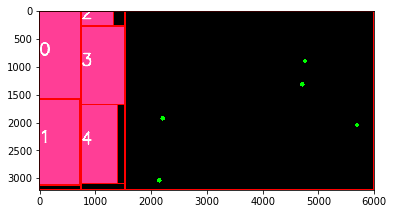

In [117]:
it = [(0, 0, 0, False), (1, 0, 1578, True), (2, 758, 0, True), (3, 758, 276, True), (4, 758, 276+1396, False)]
t = gen_tree([0, 0, widthPlates, heightPlates, 0, [], -2], it)
draw_tree(t, 0)
plt.show()

In [ ]:
cost_roadef([it])

In [ ]:
draw_trees(trees)

In [ ]:
t = gen_tree([0, 0, widthPlates, heightPlates, 0, [], -2], items_cut[0])

In [ ]:
draw_tree(t, 0)
plt.show()

In [ ]:
items_cut[1]

### Petits tests pour  le *monstre rouge*

Un *point* du *monstre rouge* est défini par ses coordonnées ainsi que les deux valeurs des pièces, en dessous ou au-dessus.
> `point = (x, y, b, g)`

**Attention complexité : il peut être plus intéressant de considérer des listes / objets mutables !**

Schéma de `[[0, 2], [1]]`

In [ ]:
class Monstre:
    def __init__(self, x, y, i):
        self.coord = (x, y)
        self.item = i        
    
    def __leq__(self, b):
        """
        Attention, relation d'ordre uniquement sur le monstre rouge mais pas générale
        """
        return self.coord[0] < b.coord[1] or (self.coord[1] > b.coord[1])
    
    def __str__(self):
        (x, y) = self.coord
        return "{} : ({}, {})".format(self.item, x, y)
    
    def x(self):
        return self.coord[0]
    
    def y(self):
        return self.coord[1]
        
    def draw(self, img, r = 10):
        (x, y) = self.coord
        font = cv2.FONT_HERSHEY_SIMPLEX
        img = cv2.rectangle(img, (0, 0), (int(x//r), int(y//r)), (0, 0, 255), -1)
        img = cv2.putText(img, str(self.item), (int(x//r + 5), int(y//r + 5)), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        return img
    
    def add(self, monstre):
        self.item = max(self.item, monstre.item)
        self.coord = (max(self.x(), monstre.x()), max(self.y(), monstre.y()))

In [ ]:
def show_monstre_rouge(monstres, r = 10):
    img = np.zeros((heightPlates//r, widthPlates//r, 3), np.uint8)
    for monstre in monstres:
        monstre.draw(img, r)
        
    plt.imshow(img)
    plt.show()

In [ ]:
monstres = [Monstre(600, 1400, 1), Monstre(1200, 700, 0)]
show_monstre_rouge(monstres)

In [ ]:

def incr_monstre_rouge_step3(monstres, monstre):

    (X, Y) = monstre.coord
    k = 0
    while k < len(monstres):
        (x, y) = monstres[k].coord
        
        if x == X:
            del monstres[k]
            continue
        
        if x > X:
            break

        if y < Y:
            del monstres[k]
            continue

        k += 1    

    monstres.insert(k, monstre)
    
    return monstres

In [ ]:
def incr_monstre_rouge(monstres, value_item, coords, dims):
    (x0, y0) = coords
    (w, h) = dims

    k = 0
    while k < len(monstres) - 1:

        # Si le plus gros élément est à gauche (1, 0, 2)
        if monstres[k].item > monstres[k + 1].item:
            if x0 >= monstres[k + 1].x() and y0 <= monstres[k + 1].y():
                monstres[k].add(monstres[k + 1])
                del monstres[k + 1]

        else:
            if x0 <= monstres[k].x() and y0 >= monstres[k].y():
                monstres[k].add(monstres[k])
                del monstres[k + 1]


        k += 1
    monstre = Monstre(x0 + w, y0 + h, value_item)
    monstres = incr_monstre_rouge_step3(monstres, monstre)
   

In [ ]:
# Tests pour l'instance A1
monstres = []
incr_monstre_rouge(monstres, 0, (0, 0), (758, 1578))
print("Step 1 : ", [str(m) for m in monstres])

incr_monstre_rouge(monstres, 1, (0, 1578), (738, 1550)) 
print("Step 2 : ", [str(m) for m in monstres])

incr_monstre_rouge(monstres, 2, (758, 0), (581, 276))
print("Step 3 : ", [str(m) for m in monstres])
show_monstre_rouge(monstres)


In [ ]:
show_monstre_rouge(monstres)